# Scale Transform Magnitude for rythimic patterns analysis.

This notebook is based on the methodology proposed in:

- _Holzapfel, A., & Stylianou, Y. (2010). Scale transform in rhythmic similarity of music. IEEE transactions on audio, speech, and language processing, 19(1), 176-185._

The Scale Transform Magnitude (STM) is a descriptor suitable for analyzing rhythmic patterns _without_ relying on beat or downbeat annotations. STM is scale invariant, therefore it is appropriate for comparing pieces with varying tempi.

This notebook serves as a demonstration of the steps involved in computing the STM feature.

In [64]:
import sys
import os
parent_dir = os.path.abspath(os.path.join('..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
%load_ext autoreload
%autoreload 2
   

import librosa
import matplotlib.pyplot as plt
import numpy as np
import IPython.display as ipd
from scripts.helpers import short_time_autocorrelation

### Load audio
The original audio file is a 10-second excerpt from the Malian Jembe dataset.

*(Polak, R., Tarsitani, S., & Clayton, M. (2018). IEMP Malian jembe. Open Science Framework.Polak, R., Tarsitani, S., & Clayton, M. (2018). IEMP Malian jembe. Open Science Framework.)*

In [86]:
audio_file = "../audio_files/clip-MJ_Maraka_1_J1.wav" # path to audio file

y, sr = librosa.load(audio_file, sr=8000) # downsampling input signal to 8kHz

y, index = librosa.effects.trim(y) # removing leading and traling silence

ipd.display(ipd.Audio(y, rate=sr)) # have a listen

### Compute STFT
The input audio signal is processed using the Short-Time Fourier Transform (STFT). The user has the option to map the magnitude spectrum onto Mel bands and/or convert it to a logarithmic scale. 

Below are the default parameters for the computation of the STFT:

    Window size: 256 samples
    Hop size: 160 samples
    Number of Mel bands: 50


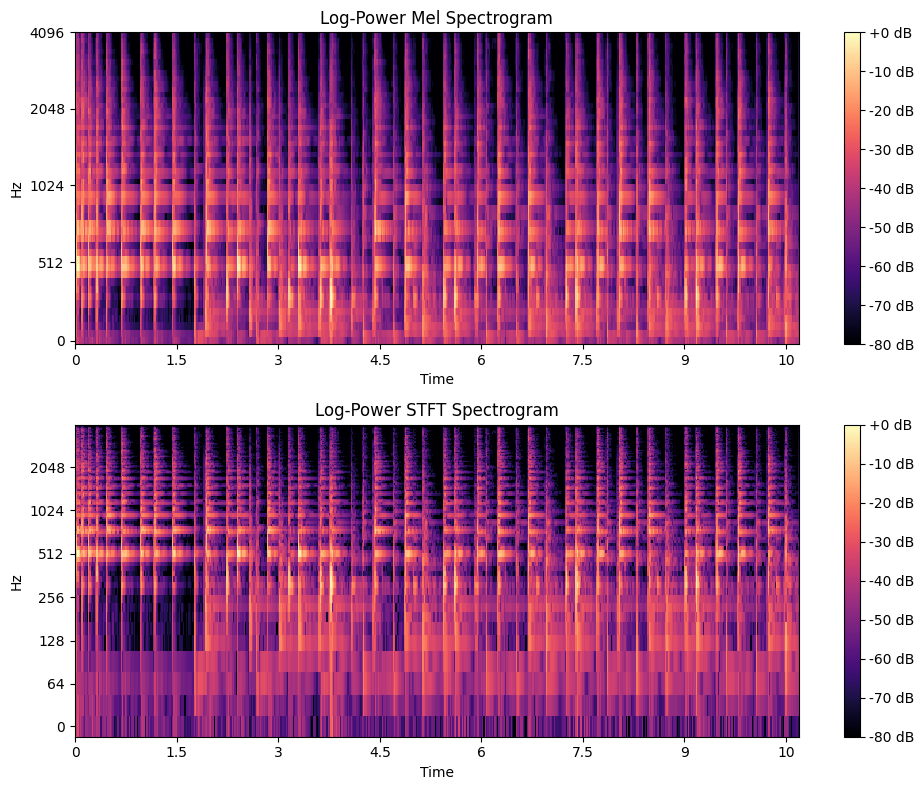

In [92]:
# define global parameters for the computation of the feature
window_size = 256  
hop_size = 160
n_mels = 50

# Mel spectrogram
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=window_size, hop_length=hop_size, power=2)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# STFT spectrogram
stft_spectrogram = librosa.stft(y=y, n_fft=window_size, hop_length=hop_size)
log_stft_spectrogram = librosa.power_to_db(np.abs(stft_spectrogram)**2, ref=np.max)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Plot Mel Spectrogram
img1 = librosa.display.specshow(log_mel_spectrogram, sr=sr, hop_length=hop_size, y_axis='mel', x_axis='time', ax=ax[0])
ax[0].set(title='Log-Power Mel Spectrogram')
fig.colorbar(img1, ax=ax[0], format='%+2.0f dB')

# Plot STFT Spectrogram
img2 = librosa.display.specshow(log_stft_spectrogram, sr=sr, hop_length=hop_size, y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='Log-Power STFT Spectrogram')
fig.colorbar(img2, ax=ax[1], format='%+2.0f dB')

plt.tight_layout()
plt.show()

### Compute Onset Strenght Signal (OSS)

Onset Strength Signal (OSS) computes a spectral flux onset strength envelope.

*Böck, Sebastian, and Gerhard Widmer. “Maximum filter vibrato suppression for onset detection.” 16th International Conference on Digital Audio Effects, Maynooth, Ireland. 2013.*

Comparing OSS computed from both Log Mel Spectrogram and Log STFT Spectrogram.

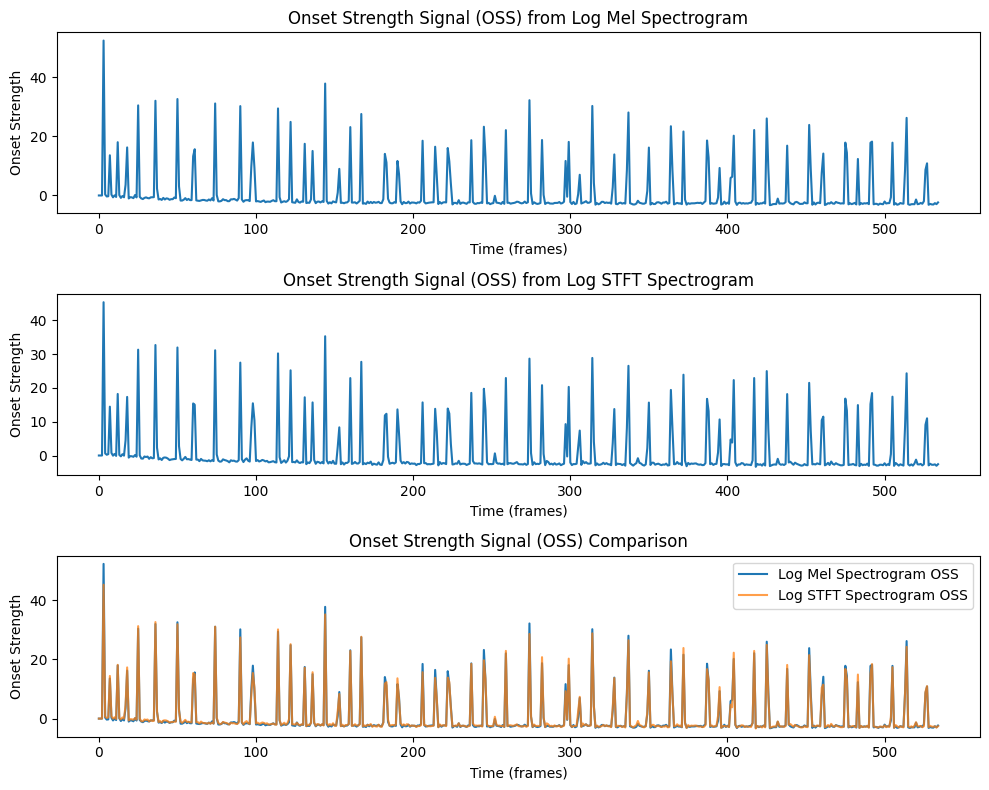

In [93]:
# Compute OSS from log mel spectrogram
oss_mel = librosa.onset.onset_strength(S=log_mel_spectrogram, sr=sr, detrend=True)

# Compute OSS from log STFT spectrogram
oss_stft = librosa.onset.onset_strength(S=log_stft_spectrogram, sr=sr, detrend=True)

# Plotting the OSS for both spectrograms
fig, ax = plt.subplots(3, 1, figsize=(10, 8))

# Plot OSS from log mel spectrogram
ax[0].plot(oss_mel)
ax[0].set(xlabel='Time (frames)', ylabel='Onset Strength', title='Onset Strength Signal (OSS) from Log Mel Spectrogram')

# Plot OSS from log STFT spectrogram
ax[1].plot(oss_stft)
ax[1].set(xlabel='Time (frames)', ylabel='Onset Strength', title='Onset Strength Signal (OSS) from Log STFT Spectrogram')

ax[2].plot(oss_mel, label='Log Mel Spectrogram OSS')
ax[2].plot(oss_stft, label='Log STFT Spectrogram OSS', alpha=0.75)
ax[2].set(xlabel='Time (frames)', ylabel='Onset Strength', title='Onset Strength Signal (OSS) Comparison')
ax[2].legend()

plt.tight_layout()
plt.show()

### Compute Autocorrelation and STM comparing different parameters for autocorrelation


(300,)
(300,)
(300,)
(300,)


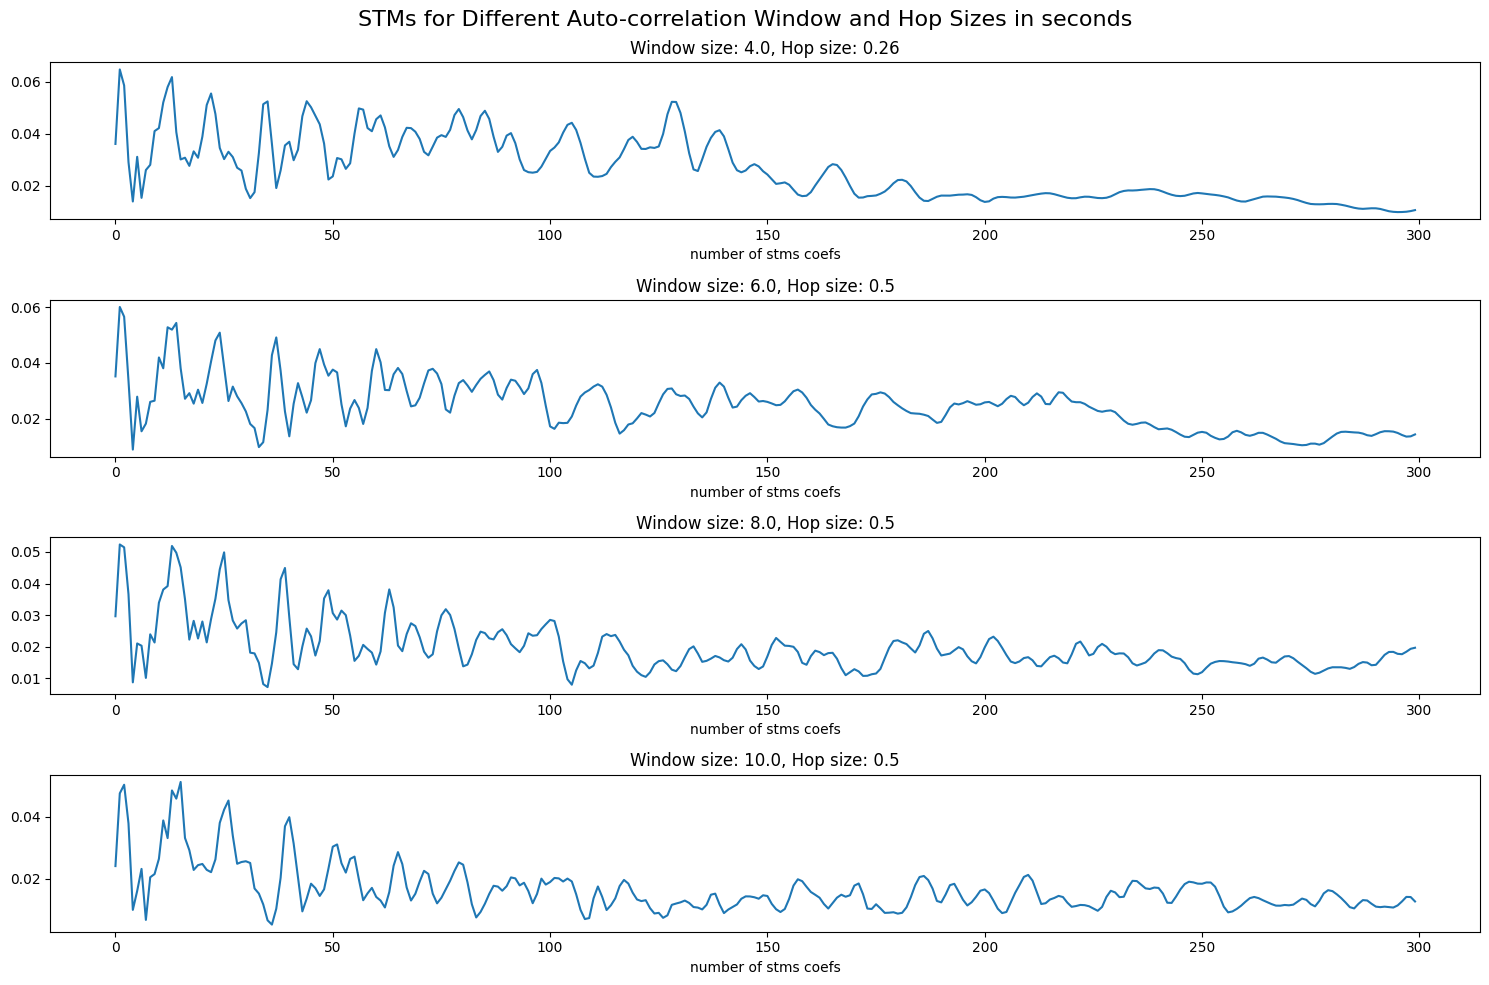

In [173]:
autocor_winsizes = [int(np.ceil(i * new_fs)) for i in [4, 6, 8, 10]]
autocor_hopsizes = [int(np.ceil(i * new_fs)) for i in [0.25, 0.5, 0.5, 0.5]]

# Placeholder for STMs
stms = {}

for win, hop in zip(autocor_winsizes, autocor_hopsizes):
    oss_ac_mel = short_time_autocorrelation(y=oss_mel, win_size=win, hop_size=hop, window_type="rectangular", with_padding=True, norm_type="max")
    scale_transform_magnitude = np.mean(np.abs(librosa.fmt(oss_ac_mel, beta=0.5, axis=0)), axis=1)[:300]
    stms[f"win{win}_hop{hop}"] = scale_transform_magnitude

# Plot the STMs for different configurations
fig, axes = plt.subplots(len(autocor_hopsizes), 1, figsize=(15, 10))
fig.suptitle('STMs for Different Auto-correlation Window and Hop Sizes in seconds', fontsize=16)

for i in range(len(autocor_winsizes)):
    k = f"win{autocor_winsizes[i]}_hop{autocor_hopsizes[i]}"
    ax = axes[i]
    print(stms[k].shape)
    ax.plot(stms[k])
    ax.set_title(f'Window size: {autocor_winsizes[i] / new_fs}, Hop size: {autocor_hopsizes[i]/new_fs}')
    ax.set_xlabel('number of stms coefs')

plt.tight_layout()
plt.show()

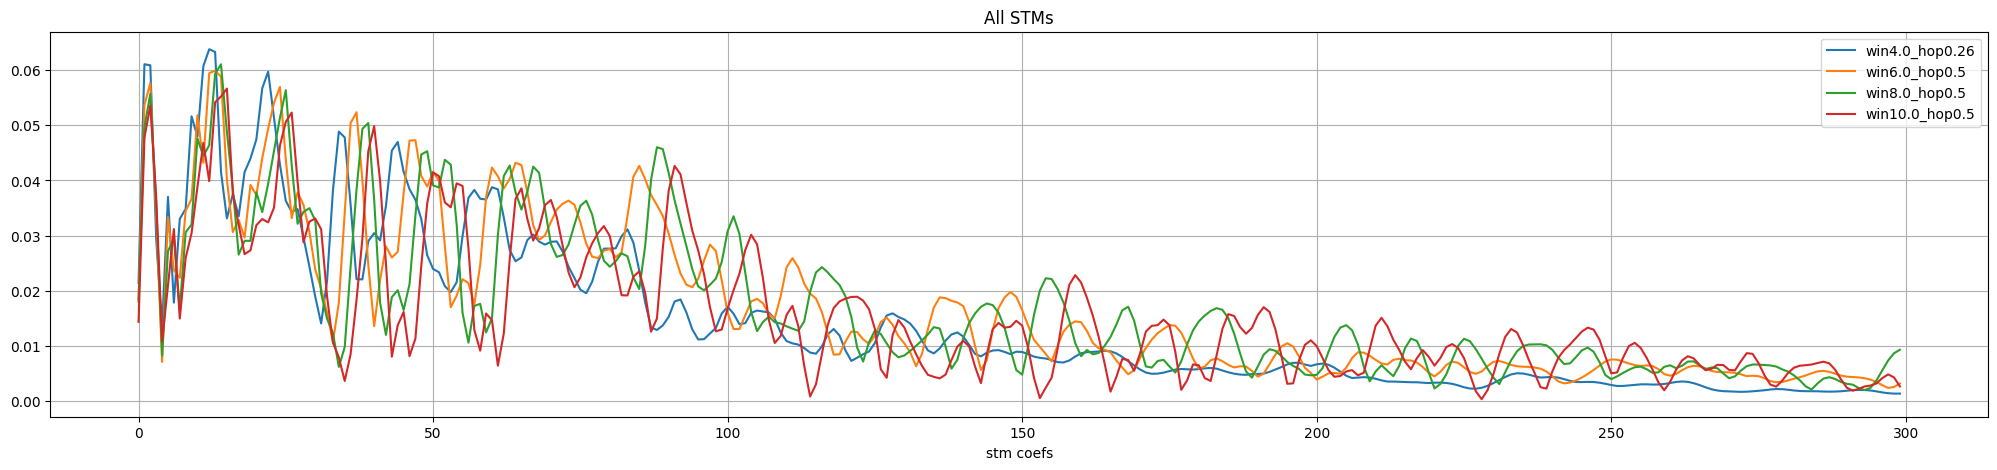

In [167]:
# Plot all STMs in one plot
plt.figure(figsize=(25, 5))
plt.title('All STMs')
for i in range(len(autocor_winsizes)):
    k = f"win{autocor_winsizes[i]}_hop{autocor_hopsizes[i]}"
    plt.plot(stms[k], label=f'win{autocor_winsizes[i]/new_fs}_hop{autocor_hopsizes[i]/new_fs}')
    
plt.xlabel('stm coefs')
plt.legend()
plt.grid(True)
plt.show()

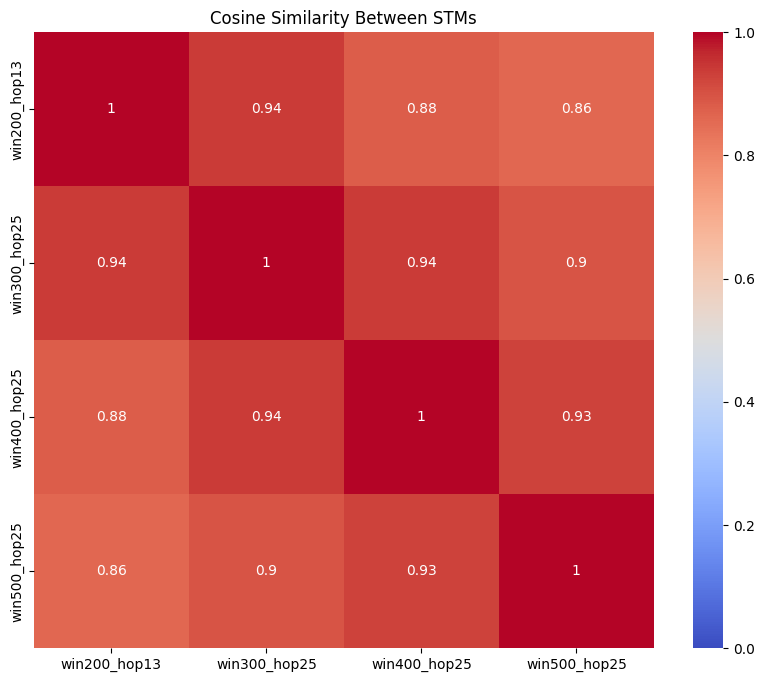

In [168]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import pandas as pd

# Compute cosine similarity between STMs
stm_keys = list(stms.keys())
stm_values = list(stms.values())
similarity_matrix = cosine_similarity(stm_values)

similarity_df = pd.DataFrame(similarity_matrix, index=stm_keys, columns=stm_keys)

# Display the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Cosine Similarity Between STMs')
plt.show()